In [ ]:
!pip install --upgrade statsmodels  dask[dataframe] xgboost

In [ ]:
import pandas as pd
import dask.dataframe as dd
from enum import unique
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet  # or "from prophet import Prophet" if using the new package name
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking, BatchNormalization
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Connecting to googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta = '/content/drive/MyDrive/postulaciones/celes_test/data-challenge-final-selection.parquet'
df = dd.read_parquet(ruta,
                     parse_dates=["Year-Month"],
                     engine = 'pyarrow'
                 )
df['Year-Month'] = dd.to_datetime(df['Year-Month'], format='%Y-%m-%d')
# Sort by Date to maintain time series order
df = df.sort_values("Year-Month").persist()

# Verify sorting
df.shape[0].compute()

179775

In [ ]:
df.head()

,Year-Month,ProductID,StoreID,Quantity,Promotion,Price,Price_Promo
0,2022-08-01,2e86ec5da9dd,4b429145d0d6,1432.1934,0.0,8.218260,8.218260
4447,2022-08-01,463bb3d2c83a,25d38033b3c2,6442.5618,0.0,7.294860,7.294860
4446,2022-08-01,14439654f469,4d46058bfe78,11.0808,0.0,6797.147400,6797.147400
4445,2022-08-01,733eaf9e280d,87ca06c2b1d3,6.4638,0.0,5.715846,5.715846
4444,2022-08-01,57d0f0ff0c89,25b2efa12034,4.6170,0.0,2475.635400,2475.635400


In [ ]:
df_preprocess = df.copy()

In [ ]:
df_preprocess['Year'] = df_preprocess['Year-Month'].dt.year
df_preprocess['Month'] = df_preprocess['Year-Month'].dt.month

In [ ]:
df_preprocess['Month_sin'] = np.sin(2 * np.pi * df_preprocess['Month'] / 12)
df_preprocess['Month_cos'] = np.cos(2 * np.pi * df_preprocess['Month'] / 12)

df_preprocess = df_preprocess.drop(columns=['Month'])  # Drop the original month column

In [ ]:
df_preprocess = df_preprocess.compute()

In [ ]:
# -------------------------------
# 2. Encode Categorical Variables
# -------------------------------
# Encode ProductID and StoreID using LabelEncoder
le_prod = LabelEncoder()
le_store = LabelEncoder()

df_preprocess['ProductID'] = le_prod.fit_transform(df_preprocess['ProductID'])
df_preprocess['StoreID'] = le_store.fit_transform(df_preprocess['StoreID'])

In [ ]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179775 entries, 0 to 179774
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Year-Month   179775 non-null  datetime64[ns]
 1   ProductID    179775 non-null  int64         
 2   StoreID      179775 non-null  int64         
 3   Quantity     179775 non-null  float64       
 4   Promotion    179775 non-null  float64       
 5   Price        179775 non-null  float64       
 6   Price_Promo  179775 non-null  float64       
 7   Year         179775 non-null  int32         
 8   Month_sin    179775 non-null  float64       
 9   Month_cos    179775 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(1), int64(2)
memory usage: 14.4 MB


In [ ]:
df_preprocess.head()

,Year-Month,ProductID,StoreID,Quantity,Promotion,Price,Price_Promo,Year,Month_sin,Month_cos
0,2022-08-01,80,60,1432.1934,0.0,8.218260,8.218260,2022,-0.866025,-0.5
4447,2022-08-01,112,29,6442.5618,0.0,7.294860,7.294860,2022,-0.866025,-0.5
4446,2022-08-01,30,63,11.0808,0.0,6797.147400,6797.147400,2022,-0.866025,-0.5
4445,2022-08-01,183,102,6.4638,0.0,5.715846,5.715846,2022,-0.866025,-0.5
4444,2022-08-01,138,28,4.6170,0.0,2475.635400,2475.635400,2022,-0.866025,-0.5


In [ ]:
# Define a cutoff date for a time-based split.
# For example, train on data up to 2023-09-30 and test on data from 2023-10-01 onward.
cutoff_date = pd.Timestamp('2023-09-01')

train_df = df_preprocess[df_preprocess['Year-Month'] <= cutoff_date].copy()
test_df  = df_preprocess[df_preprocess['Year-Month'] > cutoff_date].copy()
# Use the encoded columns for ProductID and StoreID
features = ['ProductID', 'StoreID', 'Promotion', 'Price', 'Price_Promo', 'Year', 'Month_sin', 'Month_cos']
target = 'Quantity'

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]


In [ ]:
X_train.head()

,ProductID,StoreID,Promotion,Price,Price_Promo,Year,Month_sin,Month_cos
0,80,60,0.0,8.218260,8.218260,2022,-0.866025,-0.5
4447,112,29,0.0,7.294860,7.294860,2022,-0.866025,-0.5
4446,30,63,0.0,6797.147400,6797.147400,2022,-0.866025,-0.5
4445,183,102,0.0,5.715846,5.715846,2022,-0.866025,-0.5
4444,138,28,0.0,2475.635400,2475.635400,2022,-0.866025,-0.5


In [ ]:
X_test.head()

,ProductID,StoreID,Promotion,Price,Price_Promo,Year,Month_sin,Month_cos
96630,127,128,0.0,2941.0290,2941.0290,2023,-0.866025,0.5
96631,175,66,0.0,2941.0290,2941.0290,2023,-0.866025,0.5
96632,239,28,0.0,3096.1602,3096.1602,2023,-0.866025,0.5
96636,100,151,0.0,1311.2280,1311.2280,2023,-0.866025,0.5
96634,217,64,0.0,3794.2506,3794.2506,2023,-0.866025,0.5


In [ ]:
# -------------------------------
# 4. Train the XGBoost Model
# -------------------------------
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42
)


In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# -------------------------------
# 5. Make Predictions & Evaluate
# -------------------------------
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.2f}")

Model Performance on Test Set:
RMSE: 411800.86
MAE:  87.83
R²:   0.57


In [ ]:
y_pred[:20]

array([ 11.06905  ,   9.560151 ,   8.9573345, 163.03612  ,  16.575943 ,
        12.4808655,  16.76022  ,  11.802536 ,  11.076125 ,  16.372356 ,
        16.308207 ,   9.340833 ,  12.364461 ,   9.650209 ,   7.5514402,
        11.195558 ,  11.192885 ,  16.061386 ,  15.613689 ,  14.607941 ],
      dtype=float32)

### **Prophet model**
It is not used because it does not admite multiple rows with the same date as it is in this case

### LSTM neural network

In [ ]:
df_preprocess.head()

,Year-Month,ProductID,StoreID,Quantity,Promotion,Price,Price_Promo,Year,Month_sin,Month_cos
0,2022-08-01,80,60,1432.1934,0.0,8.218260,8.218260,2022,-0.866025,-0.5
4447,2022-08-01,112,29,6442.5618,0.0,7.294860,7.294860,2022,-0.866025,-0.5
4446,2022-08-01,30,63,11.0808,0.0,6797.147400,6797.147400,2022,-0.866025,-0.5
4445,2022-08-01,183,102,6.4638,0.0,5.715846,5.715846,2022,-0.866025,-0.5
4444,2022-08-01,138,28,4.6170,0.0,2475.635400,2475.635400,2022,-0.866025,-0.5


In [ ]:
df_preprocess_lstm = df_preprocess.drop(columns=['Year', 'Month_sin', 'Month_cos'], axis = 1)
df_preprocess_lstm.head()

,Year-Month,ProductID,StoreID,Quantity,Promotion,Price,Price_Promo
0,2022-08-01,80,60,1432.1934,0.0,8.218260,8.218260
4447,2022-08-01,112,29,6442.5618,0.0,7.294860,7.294860
4446,2022-08-01,30,63,11.0808,0.0,6797.147400,6797.147400
4445,2022-08-01,183,102,6.4638,0.0,5.715846,5.715846
4444,2022-08-01,138,28,4.6170,0.0,2475.635400,2475.635400


### Saving the dataset to train the LSTM model

In [ ]:
df_preprocess_lstm.to_parquet('/content/drive/MyDrive/postulaciones/celes_test/df_preprocess_lstm.parquet')

In [ ]:
# Feature scaling (normalize numerical features)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_preprocess_lstm[['Quantity', 'Price', 'Promotion', 'Price_Promo']])

In [ ]:
# Convert dataframe back after scaling
df_preprocess_lstm[['Quantity', 'Price', 'Promotion', 'Price_Promo']] = scaled_data

In [ ]:
def create_dynamic_sequences(df, min_steps=3):
    """
    Create sequences with variable n_steps per (ProductID, StoreID).
    Sequences with less than `min_steps` observations are ignored.
    """
    sequences = []

    for (product, store), group in df.groupby(["ProductID", "StoreID"]):
        group = group.sort_values("Year-Month")  # Ensure correct order
        available_steps = len(group)

        # Use min(available_steps, max_n_steps) as n_steps
        n_steps = min(available_steps, 12)

        # Skip sequences that don't have the minimum required steps
        if n_steps < min_steps:
            continue

        data_values = group[['Quantity', 'Price', 'Promotion', 'Price_Promo']].values

        # Create sequences for this product-store pair
        for i in range(len(data_values) - n_steps):
            X_seq = data_values[i:i+n_steps, :]
            y_seq = data_values[i+n_steps, 0]  # Target = Quantity
            sequences.append((X_seq, y_seq))

    # Convert to numpy arrays
    X, y = zip(*sequences)
    return np.array(X), np.array(y)

In [ ]:
# Apply function
X, y = create_dynamic_sequences(df_preprocess_lstm)
print("Final dataset shape:", X.shape, y.shape)

Final dataset shape: (67711, 12, 4) (67711,)


In [ ]:
X[0, :, :]

array([[4.97885108e-05, 1.06251560e-01, 0.00000000e+00, 1.06251560e-01],
       [3.79972709e-05, 1.16873359e-01, 0.00000000e+00, 1.16873359e-01],
       [6.74753708e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [3.21016509e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [7.33709908e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [7.33709908e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [4.38928909e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [6.74753708e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [4.38928909e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [1.44147909e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [6.15797508e-05, 1.69757549e-01, 0.00000000e+00, 1.69757549e-01],
       [4.38928909e-05, 1.69757549e-01, 0.00000000e+00, 1.69757549e-01]])

In [ ]:
X[1, :, :]

array([[3.79972709e-05, 1.16873359e-01, 0.00000000e+00, 1.16873359e-01],
       [6.74753708e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [3.21016509e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [7.33709908e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [7.33709908e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [4.38928909e-05, 1.36711955e-01, 0.00000000e+00, 1.36711955e-01],
       [6.74753708e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [4.38928909e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [1.44147909e-05, 1.57000151e-01, 0.00000000e+00, 1.57000151e-01],
       [6.15797508e-05, 1.69757549e-01, 0.00000000e+00, 1.69757549e-01],
       [4.38928909e-05, 1.69757549e-01, 0.00000000e+00, 1.69757549e-01],
       [8.51917089e-06, 1.81812447e-01, 0.00000000e+00, 1.81812447e-01]])

In [ ]:
# Convert dataframe to numpy array
data_values = df_preprocess_lstm[['Quantity', 'Price', 'Promotion', 'Price_Promo']].values

In [ ]:
len(data_values)

179775

In [ ]:
data_values.shape

(179775, 4)

In [ ]:
# Train-test split (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
y_train[:20]

array([8.51917089e-06, 1.44147909e-05, 1.44147909e-05, 3.79972709e-05,
       2.03104109e-05, 8.51917089e-06, 2.03104109e-05, 5.56841308e-05,
       4.38928909e-05, 3.21016509e-05, 3.21016509e-05, 1.44147909e-05,
       1.44147909e-05, 8.51917089e-06, 8.51917089e-06, 2.62060309e-05,
       2.03104109e-05, 2.03104109e-05, 3.21016509e-05, 1.14640331e-04])

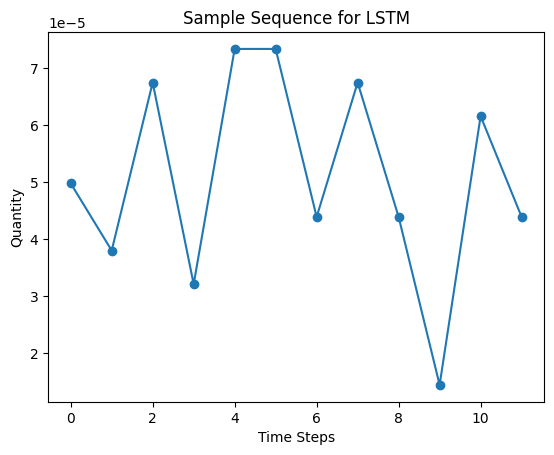

In [ ]:
sample_idx = 0  # Change this to inspect other samples
sample_sequence = X_train[sample_idx, :, 0]  # Extract first feature (Quantity)

plt.plot(range(len(sample_sequence)), sample_sequence, marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Quantity")
plt.title("Sample Sequence for LSTM")
plt.show()

<Axes: ylabel='Count'>

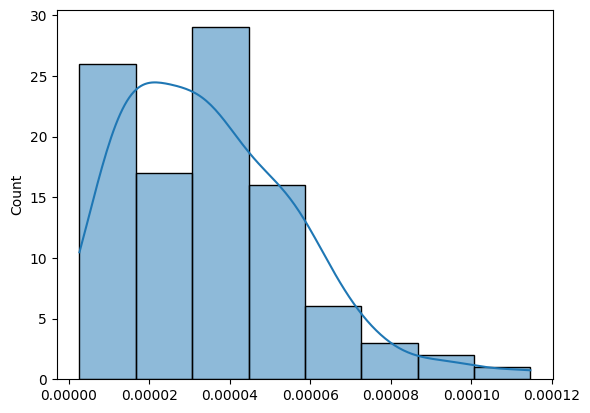

In [ ]:
import seaborn as sns
sns.histplot(y_train[:100], kde=True)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (54168, 12, 4)
y_train shape: (54168,)


In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(None, X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicting 'Quantity')
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

<ipython-input-39-692ad73594c0>:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  LSTM(50, activation='relu', return_sequences=True, input_shape=(None, X.shape[2])),


In [ ]:
# Train Model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 6.0020e-05 - val_loss: 1.7567e-06
Epoch 2/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.3414e-05 - val_loss: 1.8961e-06
Epoch 3/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.8707e-05 - val_loss: 2.1745e-06
Epoch 4/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.6152e-05 - val_loss: 2.8531e-06
Epoch 5/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.0844e-05 - val_loss: 2.2043e-06


In [ ]:
# Make Predictions
y_pred = model.predict(X_test)

# Rescale predictions back to original scale
y_test_original = scaler.inverse_transform(np.column_stack((y_test, np.zeros((y_test.shape[0], 3)))))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((y_pred.shape[0], 3)))))[:, 0]


424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [ ]:
y_test_original, y_pred_original

(array([10.1574, 12.9276,  1.8468, ...,  7.3872,  1.8468,  0.9234]),
 array([15.47926606, 15.54669134, 15.61021806, ...,  8.7619653 ,
         8.7619653 ,  8.7619653 ]))

In [ ]:
# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 83.5758
Root Mean Squared Error (RMSE): 232.5394


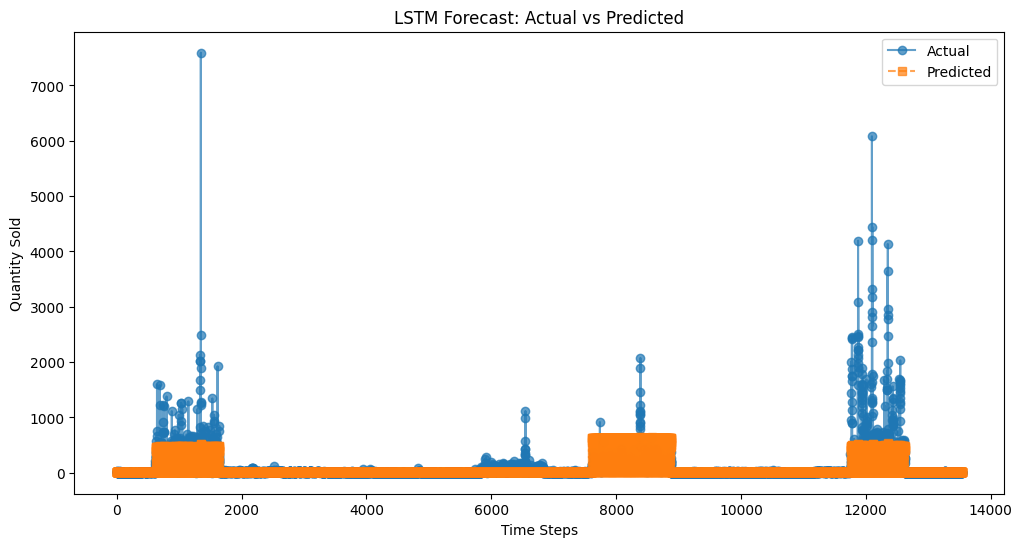

In [ ]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", marker='o', linestyle="-", alpha=0.7)
plt.plot(y_pred_original, label="Predicted", marker='s', linestyle="--", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Quantity Sold")
plt.title("LSTM Forecast: Actual vs Predicted")
plt.legend()
plt.show()

### ARIMA model

ARIMA model is not a good option because it is necessary an ARIMA model for each pair product and store. It represents a big increment to a computational level.

## Conclusion

* **LSTM** model is chosen as the final model because of the results in the metrics and its computational cost.